# Исследование гипотез

Были получены 3 датасета интернет-магазина, два последних из которых были получены в ходе проведения A/B теста:  
1. 9 гипотез по увеличению выручки, хранящие в себе информацию об охвате аудитории, влиянии, уверенности и трудозатратах. Предстоит выполнить приоритезацию этих гипотез по ICE и RICE;  

2. Массив данных о заказах и пользователей, разбитых по группам A и B. Предстоит снять и оценить показатели обеих групп, а также относительные показатели. Также необходимо проверить гипотезы об отличии показателей групп, чтобы принять решение об окончании или продолжении теста.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime as dt
import scipy.stats as stats
from scipy import stats as st

## Гипотезы

### Предобработка данных

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')

In [3]:
def information(dataset):
    return(
        print(
            display(dataset.head(10)),
            display(dataset.info()),
            display(dataset.describe(percentiles=[0.05, 0.1, 1/4, 1/2, 3/4, 0.9, 0.95, 0.99]).T),
            "Явные дубликаты:", dataset.duplicated().sum()))
                   

In [4]:
pd.set_option('display.max_colwidth', False)
information(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,99%,max
Reach,9.0,4.777778,3.153481,1.0,1.4,1.8,3.0,3.0,8.0,8.4,9.2,9.84,10.0
Impact,9.0,4.777778,3.192874,1.0,1.4,1.8,3.0,3.0,7.0,9.2,9.6,9.92,10.0
Confidence,9.0,5.555556,3.045944,1.0,1.4,1.8,3.0,7.0,8.0,8.2,8.6,8.92,9.0
Efforts,9.0,4.888889,2.803767,1.0,1.8,2.6,3.0,5.0,6.0,8.4,9.2,9.84,10.0


None None None Явные дубликаты: 0


В нашем распоряжении 9 гипотез. Дубликатов нет, но названия столбцов необходимо привести к snake_case.

In [5]:
df_hyp = hypothesis.copy()
pd.set_option('display.max_colwidth', False)
df_hyp

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [6]:
df_hyp.columns = [x.lower() for x in df_hyp.columns.values]
df_hyp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


#### Вывод

Дубликатов и неопределенных значений обнаружено не было. Названия столбцов были приведены к snake_case

### Приоритизация гипотез

#### Расчет показателей

In [7]:
df_hyp['ice'] = (df_hyp['impact'] *
                 df_hyp['confidence']/
                 df_hyp['efforts']).round(2)
df_hyp.sort_values(by='ice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


In [8]:
df_hyp['rice'] = (df_hyp['impact'] *
                 df_hyp['confidence'] *
                 df_hyp['reach']/
                 df_hyp['efforts']).round(2)
df_hyp.sort_values(by='rice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


Рассмотрим изменение приоритизации

#### Изменение приоритезации по ICE и по RICE

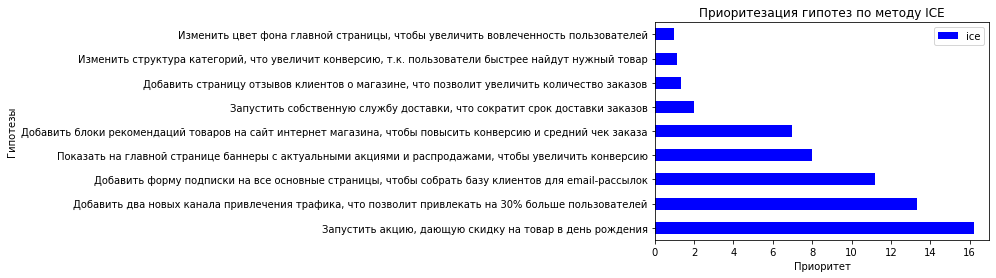

In [9]:
ax = (df_hyp[['hypothesis', 'ice']]
     .set_index('hypothesis')
     .sort_values('ice', ascending=False)
     .plot(kind='barh', color='b'))
ax.set_xlabel('Приоритет')
ax.set_ylabel('Гипотезы')
ax.set_title('Приоритезация гипотез по методу ICE')
plt.show()

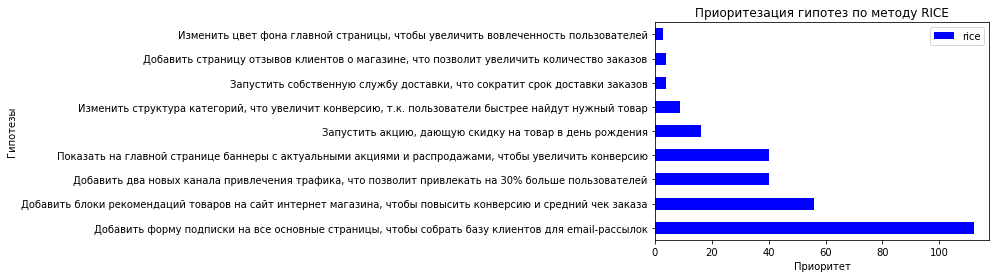

In [10]:
ax = (df_hyp[['hypothesis', 'rice']]
     .set_index('hypothesis')
     .sort_values('rice', ascending=False)
     .plot(kind='barh', color='b'))
ax.set_xlabel('Приоритет')
ax.set_ylabel('Гипотезы')
ax.set_title('Приоритезация гипотез по методу RICE')
plt.show()

#### Вывод

В обоих случаях изменение цвета фона главной страницы обладает наименьшим приоритетом. В остальном приоритеты по методам ICE и RICE меняются местами, но в обоих случаях в топ-3 входят гипотезы:  
- "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок";
- "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей".  

Разница приоритетов объясняется тем, что приоритезация по RICE учитывает охват аудитории в то время, как приотезация по ICE подразумевает использование только параметров важности и уверенности в ее успешности, так:  
- по ICE гипотеза о добавлении формы подписки на все основные каналы находится на третьем месте;  
- по RICE эта гипотеза находится на первом месте, так как затрагивает всех пользователей.

## A/B тест

В ходе A/B теста были получены данные о заказах и пользователях

In [11]:
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

### Задача

Проанализировать A/B тест:  
1. Построить график кумулятивной выручки по группам. Сделать выводы и предположения;  
2. Построить график кумулятивного среднего чека по группам. Сделать выводы и предположения;  
3. Построить график относительного изменения кумулятивного среднего чека группы B к группе A. Сделать выводы и предположения;  
4. Построить график кумулятивного среднего количества заказов на посетителя по группам. Сделать выводы и предположения;  
5. Построить график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделать выводы и предположения;  
6. Построить точечный график количества заказов по пользователям. Сделать выводы и предположения;  
7. Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей;  
8. Построить точечный график стоимостей заказов. Сделать выводы и предположения;  
9. Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов;  
10. Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделать выводы и предположения;  
11. Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделать выводы и предположения;  
12. Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделать выводы и предположения;  
13. Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделать выводы и предположения;  
14. Принять решение по результатам теста.

### Изучение данных

#### Изучение данных и предобработка

##### Заказы

In [12]:
information(orders)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,99%,max
transactionId,1197.0,2.155621e+09,1.229085e+09,1062393.0,233632506.4,430055406.0,1.166776e+09,2.145194e+09,3.237740e+09,3.832582e+09,4.067471e+09,4.239148e+09,4.293856e+09
visitorId,1197.0,2.165960e+09,1.236014e+09,5114589.0,236484761.4,407107204.6,1.111826e+09,2.217985e+09,3.177606e+09,3.909872e+09,4.080749e+09,4.256040e+09,4.283872e+09
revenue,1197.0,8.348006e+03,3.919113e+04,50.0,300.0,470.0,1.220000e+03,2.978000e+03,8.290000e+03,1.816800e+04,2.800000e+04,5.823320e+04,1.294500e+06


None None None Явные дубликаты: 0


Явных дубликатов нет, как и неопределенных значений, но поле с датой представлено в формате "object", а названия некоторых столбцов необходимо привест к snake_case.

In [13]:
df_orders = orders.copy()
df_orders['date'] = df_orders['date'].apply(pd.to_datetime)
df_orders.columns = [x.lower() for x in df_orders.columns.values]
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1197 non-null   int64         
 1   visitorid      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Рассмотрим распределение пользователей по группам

In [14]:
df_orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

Распределение неравное, разница составляет 13%

Проверим не пересекаются ли пользователи в группах

In [15]:
visit_a = set(df_orders[df_orders['group'] == 'A']['visitorid'].unique())
visit_b = set(df_orders[df_orders['group'] == 'B']['visitorid'].unique())
visit_ab = visit_a.intersection(visit_b)
print(f'Количество пересекающихся пользователей между группами A и B: {len(visit_ab)}')
print(f'Доля пересекающихся пользователей относительно массива: {len(visit_ab)/len(df_orders)}') 

Количество пересекающихся пользователей между группами A и B: 58
Доля пересекающихся пользователей относительно массива: 0.04845446950710108


Наличие 5% пересекающихся пользователей от общего объема данных может повлиять на результат теста. Удалим этих пользователей из обеих групп, так как неизвестно, какая версия повлияла на их решение.

In [16]:
df_orders = df_orders.query('visitorid not in list(@visit_ab)')
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1016 non-null   int64         
 1   visitorid      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   int64         
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


In [17]:
df_orders['group'].value_counts()

B    548
A    468
Name: group, dtype: int64

##### Пользователи

In [18]:
information(visitors)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,99%,max
visitors,62.0,607.290323,114.40056,361.0,395.55,413.8,534.0,624.5,710.5,733.7,747.9,769.39,770.0


None None None Явные дубликаты: 0


Явных дубликатов нет, как и неопределенных значений, но поле с датой представлено в формате "object".

In [19]:
df_visitors = visitors.copy()

In [20]:
df_visitors['date'] = df_visitors['date'].apply(pd.to_datetime)
df_visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [21]:
df_visitors['group'].value_counts()

B    31
A    31
Name: group, dtype: int64

##### Вывод

1. Заказы:  
    - явных дубликатов не обнаружено;  
    - неопределенных значений нет;
    - названия полей приведены к snake_case;
    - формат поля с датой был приведен к формату datetime;
    - из данных были удалены пользователи, состоящие в обеих группах;
    - распределение пользователей 468 в группе A и 548 в группе B.
2. Пользователи:
    - явных дубликатов не обнаружено;
    - неопределенных значений нет;
    - формат поля с датой был приведен к формату datetime;
    - распределение групп равное - по 31.

### Анализ A/B теста

#### Кумулятивная выручка по группам

In [22]:
df_orders_grouped_a = (df_orders[df_orders['group'] == 'A'].groupby('date')
                    .agg({'transactionid':'nunique',
                         'visitorid':'nunique',
                         'revenue':'sum'})
                    .sort_values(by='date').
                    cumsum()
                    .reset_index())

df_orders_grouped_b = (df_orders[df_orders['group'] == 'B'].groupby('date')
                    .agg({'transactionid':'nunique',
                         'visitorid':'nunique',
                         'revenue':'sum'})
                    .sort_values(by='date').
                    cumsum()
                    .reset_index())

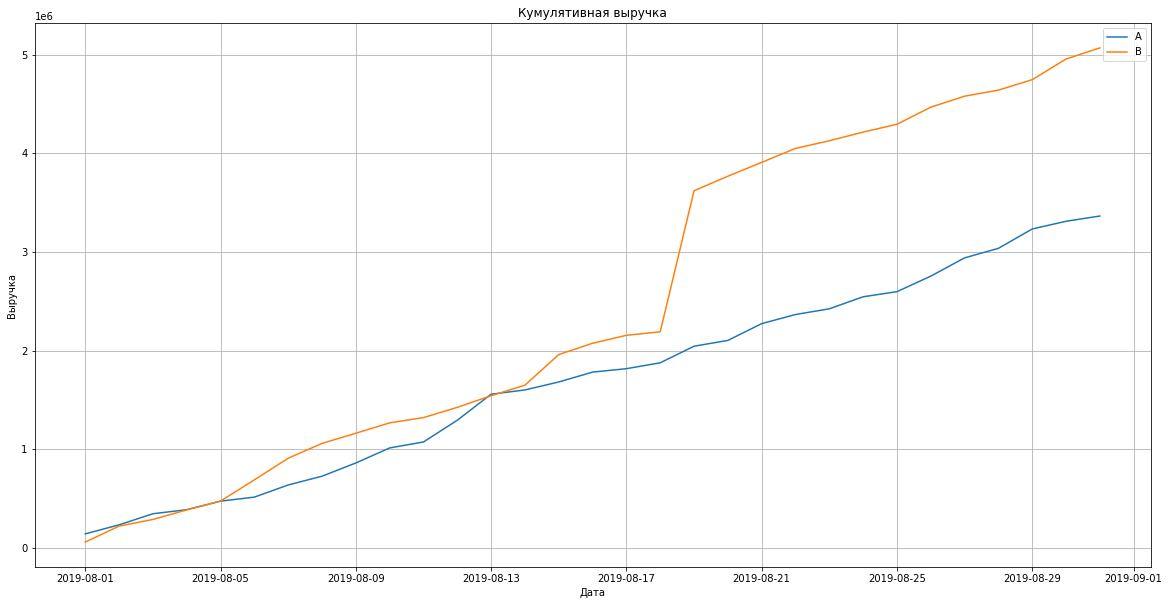

In [23]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(df_orders_grouped_a['date'], df_orders_grouped_a['revenue'], label = 'A')
ax.plot(df_orders_grouped_b['date'], df_orders_grouped_b['revenue'], label = 'B')
plt.legend()
plt.grid()
ax.set_xlabel('Дата')
ax.set_ylabel('Выручка')
plt.title('Кумулятивная выручка')
plt.show()

Выручка в течение всего периода наблюдения растет в обеих группах. Скачок в группе B может быть вызван увеличением числа заказов или их стоимостью

Text(0.5, 1.0, 'Распределение числа заказов по дням')

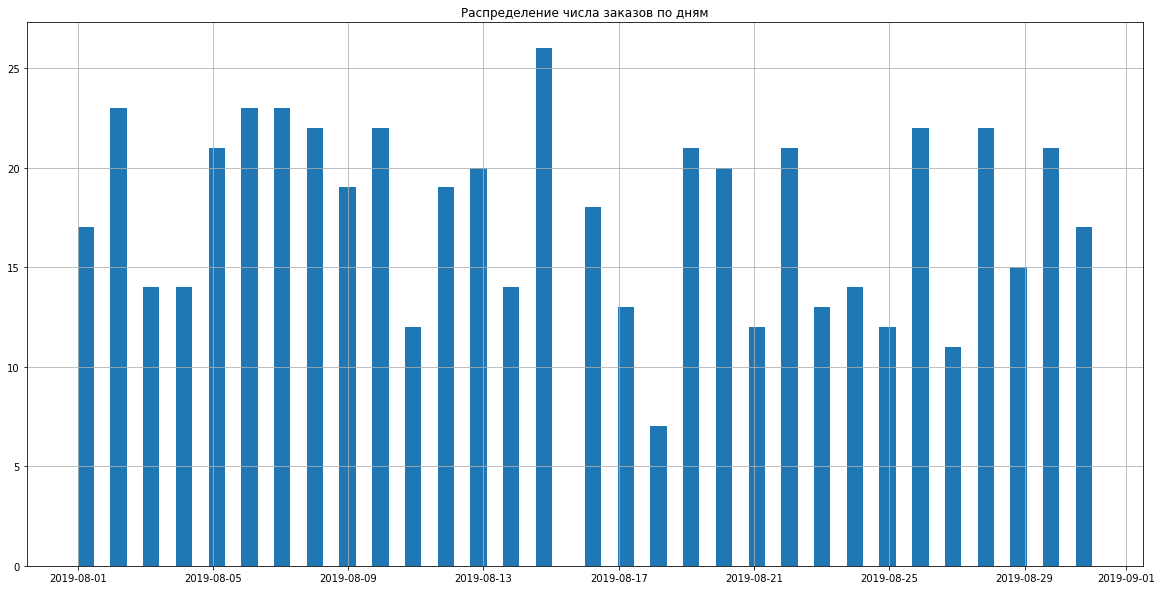

In [24]:
df_orders[df_orders['group']=='B']['date'].hist(bins=62, figsize = (20,10))
ax.set_xlabel('Дата')
ax.set_ylabel('Число заказов')
plt.title('Распределение числа заказов по дням')

Как видно из распределения с период с 17.08.2019 по 21.08.2019 после спада наблюдается резкий всплеск. Динамика изменения выручки и распределение заказов по этим датам говорят о том, что стоимость заказов росла. Т.е. скачок в группе B связан с тем, что стоимость заказов росла, но количество заказов падало, а затем произошел резкий рост числа заказов.

#### Кумулятивный средний чек

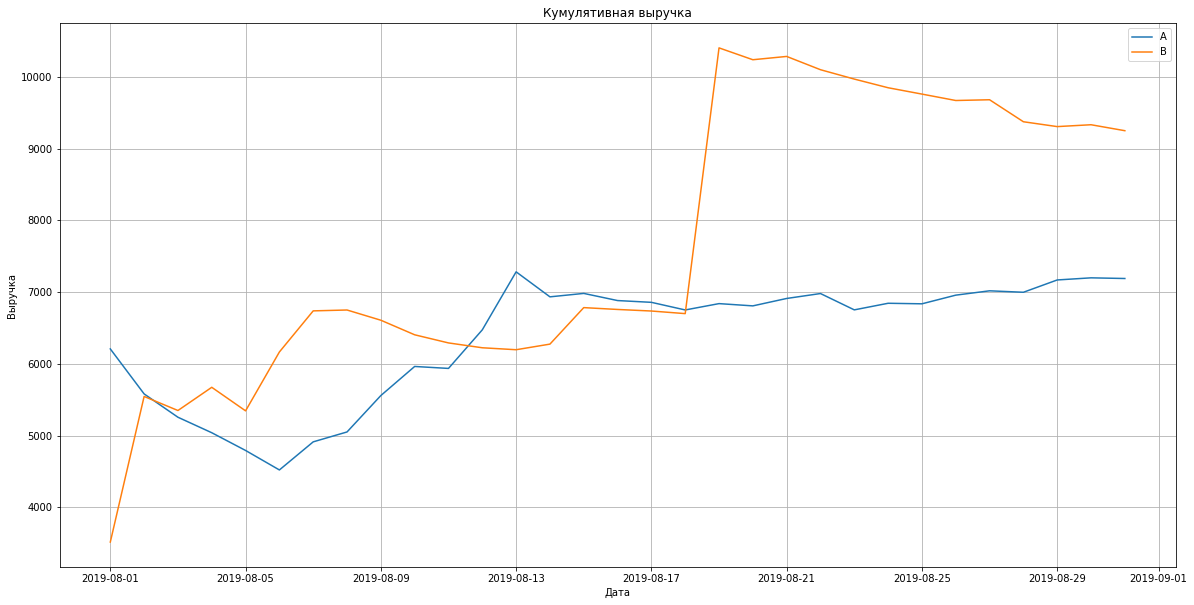

In [25]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(df_orders_grouped_a['date'],
        df_orders_grouped_a['revenue']/df_orders_grouped_a['transactionid'],
        label = 'A')
ax.plot(df_orders_grouped_b['date'],
        df_orders_grouped_b['revenue']/df_orders_grouped_b['transactionid'],
        label = 'B')
plt.legend()
plt.grid()
ax.set_xlabel('Дата')
ax.set_ylabel('Выручка')
plt.title('Кумулятивная выручка')
plt.show()

Средний чек в группе A сначала падал, а потом начал расти и стабилизировался, а в группе B в период с 17.08.2019 по 21.08.2019 средний чек испытал скачок, что говорит о том, что стоимость заказов или количество товаров в каждом заказе увеличилась.

#### Кумулятивный средний чек группы B к группе A

In [26]:
df_orders_grouped = df_orders_grouped_a.merge(df_orders_grouped_b,
                                              on='date',
                                              how='left',
                                              suffixes=('_a', '_b'))
df_orders_grouped['rel'] = ((df_orders_grouped['revenue_b'] / df_orders_grouped['transactionid_b']) / 
                           (df_orders_grouped['revenue_a'] / df_orders_grouped['transactionid_a'])
                            - 1)

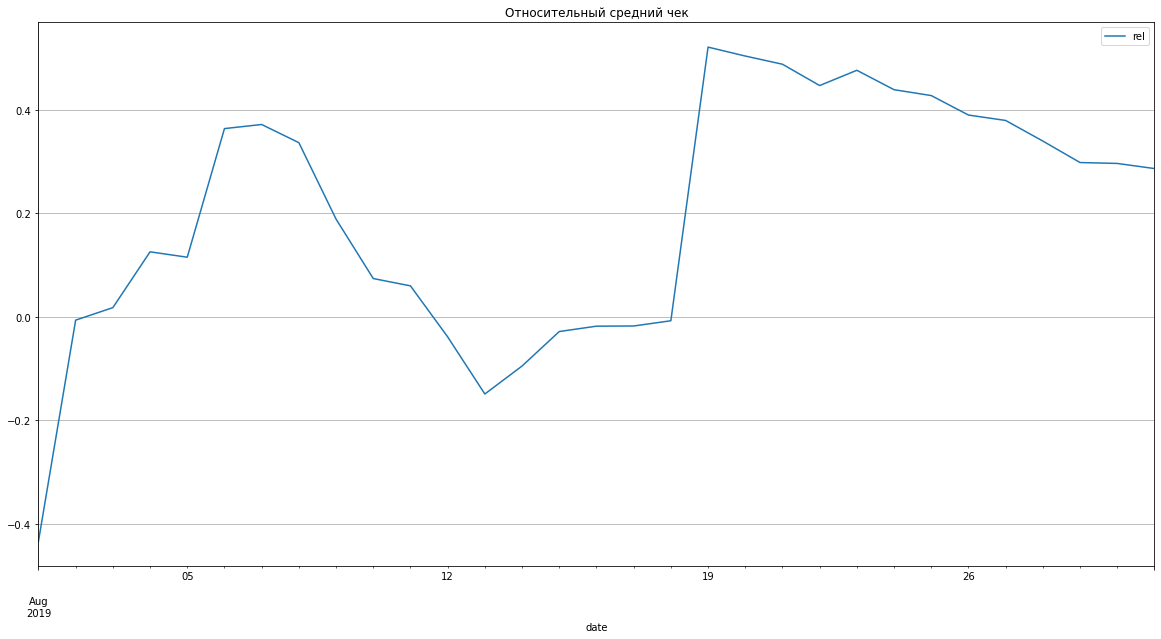

In [27]:
df_orders_grouped.plot('date', 'rel', figsize=(20,10))
ax.set_xlabel('Дата')
ax.set_ylabel('Средний чек')
plt.title('Относительный средний чек')
plt.grid()

5 и 19 августа происходят резкие скачки, связанные с тем, что в эти даты были выполнен заказы с большой общей стоимостью

#### Кумулятивное среднее количество заказов на посетителя по группам

In [28]:
df_orders_grouped_a['vis_a'] = (df_visitors[df_visitors['group'] == 'A']['visitors']
                                 .reset_index(drop=True).cumsum(axis=0))
df_orders_grouped_b['vis_b'] = (df_visitors[df_visitors['group'] == 'B']['visitors']
                                 .reset_index(drop=True).cumsum(axis=0))

df_orders_grouped_a['conv_a'] = (df_orders_grouped_a['transactionid'] / df_orders_grouped_a['vis_a'])
df_orders_grouped_b['conv_b'] = (df_orders_grouped_b['transactionid'] / df_orders_grouped_b['vis_b'])

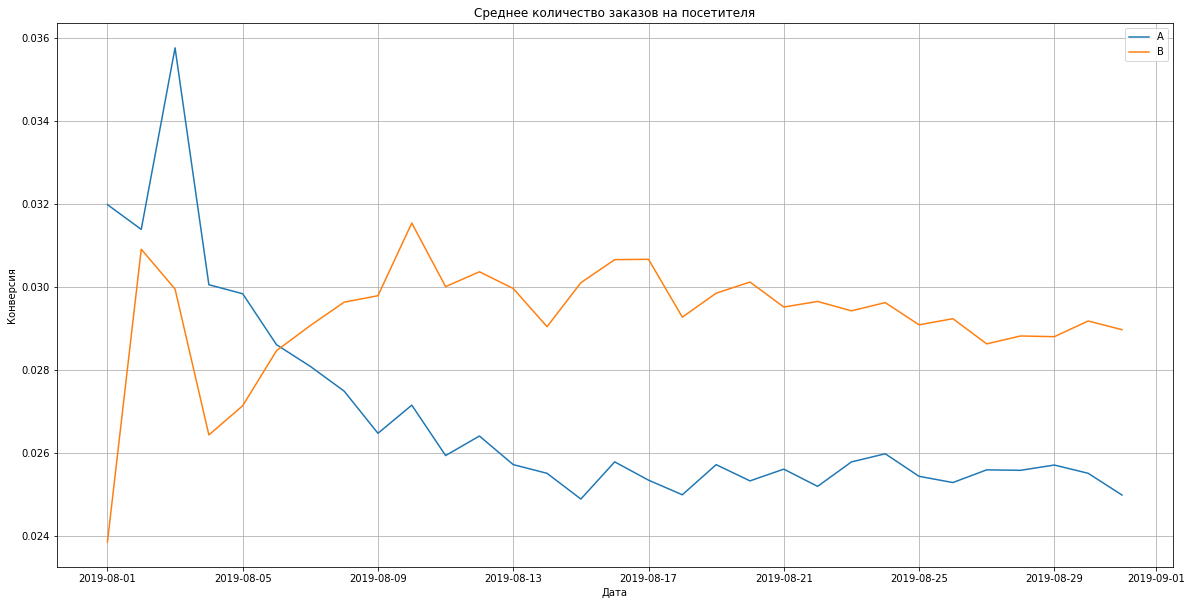

In [29]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(df_orders_grouped_a['date'], df_orders_grouped_a['conv_a'], label = 'A')
ax.plot(df_orders_grouped_b['date'], df_orders_grouped_b['conv_b'], label = 'B')
plt.legend()
plt.grid()
ax.set_xlabel('Дата')
ax.set_ylabel('Конверсия')
plt.title('Среднее количество заказов на посетителя')
plt.show()

Группы A в начале наблюдения имеет пиковую конверсию, а группа B - минимальную. Затем конверсия группы B выросла, а группы A уменьшилась

#### Относительное изменение количества заказов на посетителя группы B к группе A

In [30]:
df_orders_grouped['rel_trans'] = ((df_orders_grouped['transactionid_b']) /
                            df_orders_grouped['transactionid_a']
                            - 1)

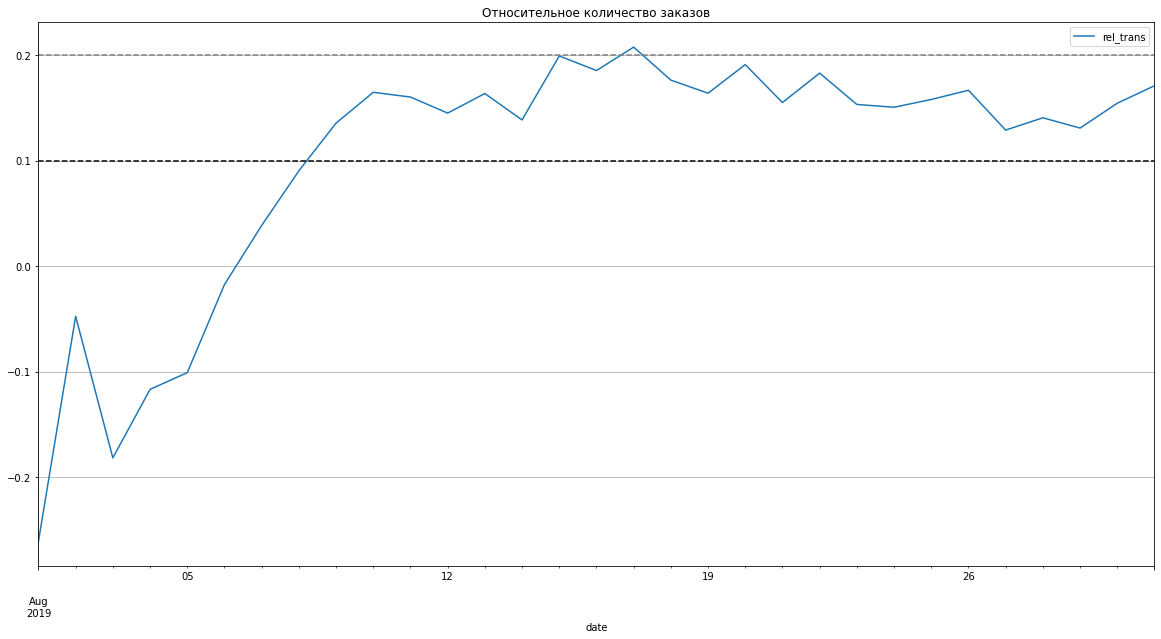

In [31]:
df_orders_grouped.plot('date', 'rel_trans', figsize=(20,10))
ax.set_xlabel('Дата')
ax.set_ylabel('Относительная конверсия')
plt.title('Относительное количество заказов')
plt.grid()
plt.axhline(y=0.1, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')

Количество заказов группы B превосходит количество заказов группы A. К 10 числу этот показатель резко возрастает и стабилизируется между 0.1 и 0.2.

#### Распределение заказов по пользователям

In [32]:
orders_by_user = df_orders.groupby('visitorid')['transactionid'].nunique()
orders_by_user.head()

visitorid
5114589     1
6958315     1
11685486    1
39475350    1
47206413    1
Name: transactionid, dtype: int64

Text(0.5, 1.0, 'Распределение количества заказов по пользователям')

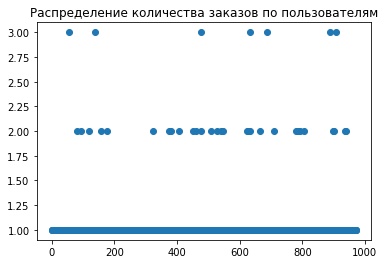

In [33]:
plt.scatter(pd.Series(range(0, len(orders_by_user))), orders_by_user)
ax.set_xlabel('Распределение клиентов')
ax.set_ylabel('Количество заказов')
plt.title('Распределение количества заказов по пользователям')

Большинство посетителей сделали один заказ, часть сделала 2 заказа, а 7 пользователей сделали по 3 заказа

#### Выбор границы для определения аномальных пользователей

In [34]:
orders_by_user.describe(percentiles=[0.05, 0.5, 0.9, 0.95, 0.99])

count    973.000000
mean     1.044193  
std      0.238090  
min      1.000000  
5%       1.000000  
50%      1.000000  
90%      1.000000  
95%      1.000000  
99%      2.000000  
max      3.000000  
Name: transactionid, dtype: float64

In [35]:
len(orders_by_user[orders_by_user>1])/len(orders_by_user)

0.03699897225077081

Большинство пользователей сделало 1 заказ. Около 4% пользователей сделали по 2 или 3 заказа - такие заказы можно отсеять. Тогда при дальнейшей работе с "очищенными" данными все пользователи будут иметь по одному заказу

#### Стоимость заказов

Text(0.5, 1.0, 'Распределение стоимости заказов')

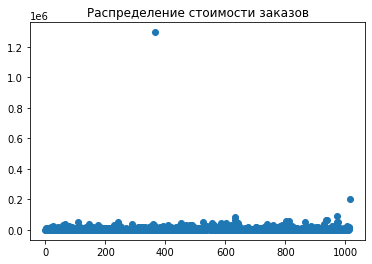

In [36]:
plt.scatter(pd.Series(range(0, len(df_orders))), df_orders['revenue'])
ax.set_xlabel('Распределение клиентов')
ax.set_ylabel('Стоимость заказов')
plt.title('Распределение стоимости заказов')

Присутствует два выброса, один свыше 1 млн. и второй в районе 200 тыс. 

Text(0.5, 1.0, 'Распределение стоимости заказов')

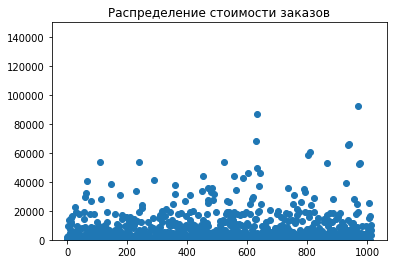

In [37]:
plt.scatter(pd.Series(range(0, len(df_orders))), df_orders['revenue'])
ax.set_xlabel('Распределение клиентов')
ax.set_ylabel('Стоимость заказов')
plt.ylim(0,150000)
plt.title('Распределение стоимости заказов')

В основной части большинство пользователей делает заказы стоимостью не более 40000. Рассмотрим это подробнее далее.

#### Выбор аномальных заказов

In [38]:
df_orders['revenue'].describe(percentiles=[0.05, 0.5, 0.9, 0.95, 0.99]).round(3)

count    1016.000   
mean     8300.815   
std      42121.992  
min      50.000     
5%       300.000    
50%      2955.000   
90%      17990.000  
95%      26785.000  
99%      53904.000  
max      1294500.000
Name: revenue, dtype: float64

5% процентов заказов дороже 27 тыс. - такие заказы можно отсеять

#### Статистическая значимость различий в среднем количестве заказов на посетителя

Выполним расчет для конверсии по "сырым данным"

In [39]:
#подготовка
orders_dt = (df_orders.groupby(['date', 'group'])
                     .agg({'transactionid':'nunique',
                           'visitorid':'nunique',
                           'revenue':'sum'})
                    .sort_values(by=['date', 'group'])
                    .reset_index())
orders_dt

,date,group,transactionid,visitorid,revenue
0,2019-08-01,A,23,19,142779
1,2019-08-01,B,17,17,59758
2,2019-08-02,A,19,18,91602
3,2019-08-02,B,23,22,162043
4,2019-08-03,A,24,24,112473
...,...,...,...,...,...
57,2019-08-29,B,15,15,106100
58,2019-08-30,A,9,8,78180
59,2019-08-30,B,21,21,209223
60,2019-08-31,A,8,8,53243


In [40]:
a = (df_orders_grouped_a[['date', 'transactionid', 'revenue', 'vis_a']]
     .merge(orders_dt[orders_dt['group'] == 'A'][['date', 'transactionid', 'revenue']],
           on='date', how='left'))

a = a.merge(df_visitors[visitors['group'] == 'A'][['date', 'visitors']], on = 'date', how='left')

a.set_axis(['date', 'orders', 'revenue', 'visitors', 'orders_daile', 'revenue_daily', 'visitors_daily'],
           axis='columns',
           inplace=True)
a.head()

,date,orders,revenue,visitors,orders_daile,revenue_daily,visitors_daily
0,2019-08-01,23,142779,719,23,142779,719
1,2019-08-02,42,234381,1338,19,91602,619
2,2019-08-03,66,346854,1845,24,112473,507
3,2019-08-04,77,388030,2562,11,41176,717
4,2019-08-05,99,474413,3318,22,86383,756


In [41]:
b = (df_orders_grouped_b[['date', 'transactionid', 'revenue', 'vis_b']]
     .merge(orders_dt[orders_dt['group'] == 'B'][['date', 'transactionid', 'revenue']],
           on='date', how='left'))

b = b.merge(df_visitors[visitors['group'] == 'B'][['date', 'visitors']], on = 'date', how='left')

b.set_axis(['date', 'orders', 'revenue', 'visitors', 'orders_daile', 'revenue_daily', 'visitors_daily'],
           axis='columns',
           inplace=True)
b.head()

,date,orders,revenue,visitors,orders_daile,revenue_daily,visitors_daily
0,2019-08-01,17,59758,713,17,59758,713
1,2019-08-02,40,221801,1294,23,162043,581
2,2019-08-03,54,288850,1803,14,67049,509
3,2019-08-04,68,385740,2573,14,96890,770
4,2019-08-05,89,475648,3280,21,89908,707


In [42]:
order_by_users_a = (df_orders[df_orders['group'] == 'A'].groupby('visitorid', as_index=False)
                   .agg({'transactionid':pd.Series.nunique}))
order_by_users_b = (df_orders[df_orders['group'] == 'B'].groupby('visitorid', as_index=False)
                   .agg({'transactionid':pd.Series.nunique}))

In [43]:
sample_a = pd.concat([order_by_users_a['transactionid'], 
                     pd.Series(0,index=np.arange(a['visitors_daily'].sum() - len(order_by_users_a['transactionid'])), 
                               name='orders')], axis=0)
sample_b = pd.concat([order_by_users_b['transactionid'], 
                     pd.Series(0,index=np.arange(b['visitors_daily'].sum() - len(order_by_users_b['transactionid'])), 
                               name='orders')], axis=0)

H0: Конверсии в группах A и B не отличаются  
H1: Конверсии в группах A и B отличаются

In [44]:
alpha = 0.05
p_value = st.mannwhitneyu(sample_a, sample_b)[1]

print('p_value: {0:.3f}'.format(p_value))

if p_value < alpha:
    print('Отвергаем нулевую теорию: между группами есть разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными')
print('Относительная разница: {0:.1%}'.format(sample_b.mean()/sample_a.mean()-1))    

p_value: 0.011
Отвергаем нулевую теорию: между группами есть разница
Относительная разница: 16.0%


#### Статистическая значимость различий в среднем чеке

H0: Средний чек в группах A и B не отличается  
H1: Средний чек в группах A и B отличается

In [45]:
p_value = st.mannwhitneyu(df_orders[df_orders['group']=='A']['revenue'],
                          df_orders[df_orders['group']=='B']['revenue'])[1]

print('p_value: {0:.3f}'.format(p_value))

if p_value < alpha:
    print('Отвергаем нулевую теорию: между группами есть разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными')
print('Относительная разница: {0:.1%}'.format(df_orders[df_orders['group']=='B']
                                              ['revenue'].mean()/df_orders[df_orders['group']=='A']['revenue'].mean()-1))    

p_value: 0.829
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Относительная разница: 28.7%


#### Статистическая значимость различий в среднем количестве заказов по "очищенным" данным

In [46]:
df_orders.head()

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [47]:
clear_orders = df_orders.groupby('visitorid')['transactionid'].count().reset_index()
clear_orders = clear_orders[clear_orders['transactionid'] > 1]
reach_orders = df_orders[df_orders['revenue'] > 27000]['visitorid'].reset_index(drop=True)
annomaly_users = pd.Series( (list(clear_orders) + list(reach_orders)), name='visitorid').drop_duplicates()

annomaly_users.head()

0    visitorid    
1    transactionid
2    2947100995   
3    787824685    
4    3288820196   
Name: visitorid, dtype: object

In [48]:
clear_sample_a = pd.concat([order_by_users_a.query('not visitorid in @annomaly_users')['transactionid'], 
                          pd.Series(0, index=np.arange(a['visitors_daily'].sum() - len(order_by_users_a['transactionid'])), 
                                    name='orders')], axis=0)
clear_sample_b = pd.concat([order_by_users_b.query('not visitorid in @annomaly_users')['transactionid'], 
                          pd.Series(0, index=np.arange(b['visitors_daily'].sum() - len(order_by_users_b['transactionid'])), 
                                    name='orders')], axis=0)

H0: Конверсии в группах A и B не отличаются  
H1: Конверсии в группах A и B отличаются

In [49]:
p_value = st.mannwhitneyu(clear_sample_a, clear_sample_b)[1]

print('p_value: {0:.3f}'.format(p_value))

if p_value < alpha:
    print('Отвергаем нулевую теорию: между группами есть разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными')
print('Относительная разница: {0:.1%}'.format(clear_sample_b.mean()/clear_sample_a.mean()-1))    

p_value: 0.017
Отвергаем нулевую теорию: между группами есть разница
Относительная разница: 15.6%


По "очищенным" данным также есть разница, а относительная разница уменьшилась на 0.4 процентных пункта

#### Статистическая значимость различий в среднем чеке по "очищенным" данным

H0: Средний чек в группах A и B не отличается  
H1: Средний чек в группах A и B отличается

In [50]:
p_value = st.mannwhitneyu(df_orders.query('group == "A" and visitorid not in @annomaly_users')['revenue'],
                          df_orders.query('group == "B" and visitorid not in @annomaly_users')['revenue'])[1]

print('p_value: {0:.3f}'.format(p_value))

if p_value < alpha:
    print('Отвергаем нулевую теорию: между группами есть разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными')
print('Относительная разница: {0:.1%}'.format(df_orders.query(
    'group == "B" and visitorid not in @annomaly_users')['revenue'].mean()/
                                              df_orders.query('group == "A" and visitorid not in @annomaly_users')['revenue'].mean()-1)) 

p_value: 0.741
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Относительная разница: -5.3%


По "очищенным" данным нулевая гипотеза не отвергается. Средний чек в группах A и B не отличается

#### Вывод

1. Выручка в течение всего периода наблюдения растет в обеих группах. Выручка в группе B испытывает резкий скачок 19.08.2019;  
2. В течение всего  периода наблюдения средний чек растет, за исключением некоторых периодов. Так в самом начала средний чек группы A падал, а потом начал рост с последующие выравниванием, а группа B имеет несколько скачков - в начале и в серидине наблюдения с последующим плавным затуханием;  
3. Динамика относительного среднего чека имеет резкие спады и падения, ввиду того, что в эти даты были сделаны заказы с большой стоимостью корзины;  
4. В начале наблюдения группа A достагает пиковой конверсии и в последующем падает на протяжении всего наблюдения. Группа B имеет минимальную конверсию, достигает почти максимального значения и снова падает с последующим возрастанием и выравниванием;  
5. Количество заказов на посетителя группы B превосходит количество заказов группы A. С самого начала наблюдения показатель относительного количества заказов на посетителя группы B к группе A растет, а затем стабилизируется между 0.1 и 0.2;  
6. Большинство посетителей сделало 1 заказ - около 95%. Остальные посетителю сделал по 2-3 заказа, что считается выбросом;  
7. Большинство посетителей сделало заказ на сумма, не превышающую 27000;  
8. По "сырым" данным конверсии в группах A и B имеют раличия;  
9. По "сырым" данным средний чек не имеет различий в группах A и B;  
10. По "очищенным" данным конверсии в группах A и B имеют различия;  
11. По "очещенным" данным средний чек не имеет различий в группах A и B.  

Нет смысла продолжать тест. Следует отдать победу группе B, так как ее конверсия значительно превышает конверсию группы A.

## Вывод

### Гипотезы

1. Была выполнена преобработка данных:
    - дубликатов и неопределенных значений нет;  
    - был изменен формат в поле с датой;  
    - названия столбцов приведены к snake_case;
2. Была выполнена приоритезация гипотез по ICE и RICE. В случае с RICE, помимо параметров важности и уверенности, используется параметр охвата аудитории, из-за чего по гипотезы по RICE имеют больший приоритет, чем по ICE, если они охватывают больше аудитории. В обоих случаях в топ-3 приоритетов входят "Добавить форму подписка на все основные страницы, чтобы собрать базу клиентов для email-рассылок" и "Добавить два новых канала привлечения трафика, что позваолит привлекать на 30% больше пользователей".

### A/B тест

Была выполнена предобработка данных. Изменен формат поля с датой. Дубликатов и неопределенных значений обнаружено не было, однако были обнаружены пользователи, участвовашие в ходе теста в обеих группах - такие пользователи были удалены, так как их наличие может дать необъективную картину исследования. Рекомендуется выполнить операции по предотвращению попадания пользователей в обе группы.

Были получены выходные данные A/B теста. По итогам расчета показателей было выявлено, что конверсия группы B значительно превышает конверсию группы A, из-за чего следует отдать победу группе B и остановить тест. При этом гипотезы о различии показателей конверсии и среднего чека имеют один и тот же результат как для "сырых" данных, так и для "очищенных" данных -  конверсия обеих групп имеет различия, а средний чек нет. В частности были выполнены шаги по снятию и изучению различных показателей:  
1. Выручка в обеих группах растет;
2. Средний чек растет;
3. Динамика относительного среднего чека имеет два пика, с резким подъемом в начале и плавным падением в конце. Такие пики могут быть связаны с выбросами, представленными тем, что в эти даты были выполнены заказы с большой стоимостью;  
4. По сравнению с началом наблюдения конверсия группы A падает в течение всего периода наблюдения, а у группы B возрастает в начале и выравнивается к концу;  
5. Относительная конверсия растет в начале наблюдения и начинает выравниваться в середине между 0.1 и 0.2;  
6. Было обнаружено, что большинство пользователей делает по одному заказу, а их чек не превышает 27 000;  
7. Были проверены гипотезы о различии конверсий и среднего чека обеих групп по "сырым" и "очищенным" данным -  в обоих случаях результат одинаковый - конверсия не имеет различий, а средний чек имеет.